In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install monai==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.7 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel
from tqdm import tqdm
from monai import transforms
import gc

In [ ]:
root_dir = "/content/drive/MyDrive/BRATS_2021/BraTS2021/"
tar_dir = "/content/drive/MyDrive/diff_repaint/data/"
dir_list = sorted(os.listdir(root_dir))
dir_list = dir_list[1:]

In [ ]:
split_dict = {'train': 938, 'val': 62, 'test': 251}
import random
dir_train = sorted(random.sample(dir_list, split_dict['train']))
dir_val = sorted(random.sample([elem for elem in dir_list if elem not in dir_train], split_dict['val']))
dir_test = sorted([elem for elem in dir_list if (elem not in dir_train and elem not in dir_val)])

In [ ]:
def normalize_image(image):

    temp_dict = {'image': image}

    transform = transforms.ScaleIntensityRangePercentilesd(
        keys="image",
        lower=0.0,
        upper=100.0,
        b_min=0.0,
        b_max=1.0
    )

    return transform(temp_dict)['image']

In [ ]:
def preprocess(target_dir, mode):

    count = 0

    patient_list = []

    if mode == 'train':
        patient_list = dir_train
    elif mode == 'val':
        patient_list = dir_val
    elif mode == 'test':
        patient_list = dir_test

    for dir in tqdm(patient_list):
        # if count >= 150:
        #     break

        t1_image_path = os.path.join(root_dir, dir, dir + '_t1.nii.gz')
        t1ce_image_path = os.path.join(root_dir, dir, dir + '_t1ce.nii.gz')
        t2_image_path = os.path.join(root_dir, dir, dir + '_t2.nii.gz')
        flair_image_path = os.path.join(root_dir, dir, dir + '_flair.nii.gz')
        seg_path = os.path.join(root_dir, dir, dir + '_seg.nii.gz')

        t1 = nibabel.load(t1_image_path)
        t1 = t1.get_fdata()
        t1 = normalize_image(t1[:, :, 46: 96])

        t1ce = nibabel.load(t1ce_image_path)
        t1ce = t1ce.get_fdata()
        t1ce = normalize_image(t1ce[:, :, 46: 96])

        t2 = nibabel.load(t2_image_path)
        t2 = t2.get_fdata()
        t2 = normalize_image(t2[:, :, 46: 96])

        flair = nibabel.load(flair_image_path)
        flair = flair.get_fdata()
        flair = normalize_image(flair[:, :, 46: 96])

        label = nibabel.load(seg_path)
        label = label.get_fdata()[:, :, 46: 96]

        image = np.stack((t1, t1ce, t2, flair))

        data_dict = {
            "image": [],
            "label": [],
            "weak_label": [],
        }

        for i in range(50):
            image_padded = np.zeros((4, 256, 256))
            label_padded = np.zeros((256, 256))
            image_padded[:, 8:-8, 8:-8] = image[:, :, :, i]
            label_padded[8:-8, 8:-8] = label[:, :, i]
            weak_label = 1 if np.max(label_padded) > 0 else 0

            output_path = os.path.join(target_dir, mode + "_slice_" + str(count).zfill(5) + '.npz')
            np.savez_compressed(output_path, image=np.array(image_padded), label=np.array(label_padded), weak_label=np.array(weak_label))
            count += 1

        # count += 1
        del t1, t1ce, t2, flair, label
        gc.collect()

In [ ]:
preprocess(tar_dir + 'train_slices/', 'train')

100%|██████████| 938/938 [1:44:19<00:00,  6.67s/it]


In [ ]:
path = "/content/drive/MyDrive/diff_repaint/data/train_slices/train_slice_00130.npz"
loaded_data = np.load(path)

In [ ]:
def visualize(loaded_data):
    print(loaded_data["weak_label"])
    fig = plt.figure()
    ax = plt.subplot(2, 3, 1)
    ax.imshow(loaded_data["image"][0, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 2)
    ax.imshow(loaded_data["image"][1, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 3)
    ax.imshow(loaded_data["image"][2, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 4)
    ax.imshow(loaded_data["image"][3, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 5)
    ax.imshow(loaded_data["label"][:, :])
    plt.axis("off")

    plt.tight_layout()

1


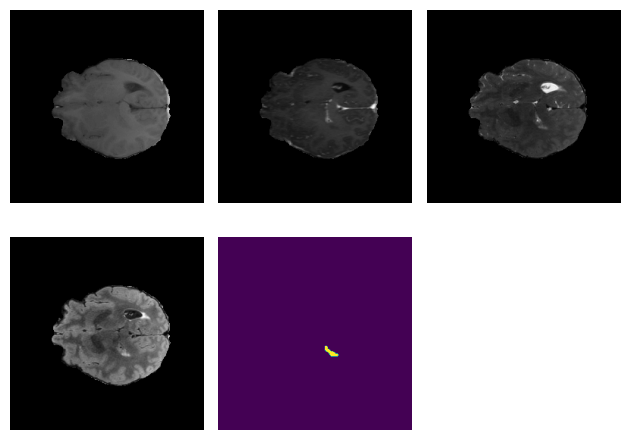

In [ ]:
visualize(loaded_data)

In [ ]:
dir = "/content/drive/MyDrive/diff_repaint/data/train_slices/"
dirs = sorted(os.listdir(dir))

In [ ]:
print(len(dirs))

46828


In [ ]:
preprocess(tar_dir + 'test_slices/', 'test')

100%|██████████| 251/251 [27:05<00:00,  6.48s/it]


In [ ]:
print(dirs[:10])

['train_slice_00072.npz', 'train_slice_00073.npz', 'train_slice_00074.npz', 'train_slice_00075.npz', 'train_slice_00076.npz', 'train_slice_00077.npz', 'train_slice_00078.npz', 'train_slice_00079.npz', 'train_slice_00080.npz', 'train_slice_00081.npz']
